In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind,f_oneway, ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Amazon Product Analysis

### Radostin Dimkov - dimkov41@hotmail.com

### Introduction

In a world where Amazon is the big leader in online shopping, there's a huge amount of information waiting to be understood. This project aims to analyze and figure out the details about more than 1000 different things you can buy on Amazon India. The reason for choosing Amazon India is because I came across this dataset freely available on the internet. Imagine navigating through a maze of facts and numbers. This project wants to find the important bits of knowledge hidden in all of that. The data has lots of info like product names, categories (what type of stuff it is), prices, how customers rate them, and what customers say in reviews. By looking really closely at this data, the project wants to find patterns and connections. This helps both Amazon and the people who shop there. 

For Amazon, studying this data is like having a map to help them in a confusing market. It shows which products are liked a lot and what things are trendy. This way, Amazon can set the right prices and do advertising in smart ways. This makes Amazon better at what it does, compared to others.

As the project goes on, it uses the newest ways to look at data and make cool pictures that show what's happening. These pictures tell stories about products prices and ratings.
    

### Data processing


In [3]:
file_path = 'amazon.csv'
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path, index_col=0)

In [4]:
df = df.rename(columns = {"actual_price_in_rupee" : "actual_price", "discounted_price_in_rupee": "discounted_price"})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1465 entries, B07JW9H4J1 to B01486F4G6
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_name         1465 non-null   object
 1   category             1465 non-null   object
 2   discounted_price     1465 non-null   object
 3   actual_price         1465 non-null   object
 4   discount_percentage  1465 non-null   object
 5   rating               1465 non-null   object
 6   rating_count         1463 non-null   object
 7   about_product        1465 non-null   object
 8   user_id              1465 non-null   object
 9   user_name            1465 non-null   object
 10  review_id            1465 non-null   object
 11  review_title         1465 non-null   object
 12  review_content       1465 non-null   object
 13  img_link             1433 non-null   object
 14  product_link         1388 non-null   object
dtypes: object(15)
memory usage: 183.1+ KB


In [6]:
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 1465
Number of columns: 15


#### Navigating the Data Terrain

    

    product_id - Product ID

    product_name - Name of the Product

    category - Category of the Product

    discounted_price - Discounted Price of the Product

    actual_price - Actual Price of the Product

    discount_percentage - Percentage of Discount for the Product

    rating - Rating of the Product

    rating_count - Number of people who voted for the Amazon rating

    about_product - Description about the Product

    user_id - ID of the user who wrote review for the Product

    user_name - Name of the user who wrote review for the Product

    review_id - ID of the user review

    review_title - Short review

    review_content - Long review

    img_link - Image Link of the Product

    product_link - Official Website Link of the Product



In [7]:
for column in df.columns:
    print(column)

product_name
category
discounted_price
actual_price
discount_percentage
rating
rating_count
about_product
user_id
user_name
review_id
review_title
review_content
img_link
product_link


In our dataset, we've noticed that both the `Image link` and `Product link` columns have missing values. Since these columns don't hold significant importance for our project's goals, a practical decision would be to remove them from the dataset.

By doing this, we can simplify our data while focusing on the key aspects relevant to our project. Removing these columns, which contain missing information and aren't critical to our analysis, will help streamline the dataset and make it easier to work with.

In [8]:
df.drop(['img_link', 'product_link'], axis=1, inplace=True)

We noticed that in the dataset, there are missing values `NaN` in the `Rating Count` column and incorrect data in `Rating` column. Using the information we gained from inspecting the data with the `.info()` function, we're taking an action. If there is no information available about the number of ratings `Rating Count` for a product or `Rating` data is invalid, we set them to -1. This helps us clearly indicate that there are no ratings available for those products.

In [9]:
df.loc[df['rating_count'].isna() | (df['rating'] == '|') | df['rating'].isna(), ['rating', 'rating_count']] = -1

We need to make sure that values are in the right format. So, we're changing them to the type that works best for numbers. This helps us do accurate calculations and understand the data better.

In [10]:
df['rating_count'] = df['rating_count'].str.replace(',', '')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce').fillna(-1).astype(int)
df['rating'] = df['rating'].astype(float)
df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
df['actual_price'] = df['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)

It's often better to convert the "discount_percentage" column with values like "40%" to a numerical format so that you can perform calculations and analyses more easily.

In [11]:
df['discount_percentage'] = df['discount_percentage'].str.rstrip('%').astype(float)

Since the category values are complex and contains multiple subcategories separated by pipe `|`, so we will extract and will work only with main category. 

In [12]:
# Extract the first value before the first "|" character, i.e. main group
df['category_simplified'] = df['category'].str.split('|').str[0]

In [13]:
df.columns

Index(['product_name', 'category', 'discounted_price', 'actual_price',
       'discount_percentage', 'rating', 'rating_count', 'about_product',
       'user_id', 'user_name', 'review_id', 'review_title', 'review_content',
       'category_simplified'],
      dtype='object')

In [14]:
df.head(5)

,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,category_simplified
product_id,,,,,,,,,,,,,,
B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64.0,4.2,24269,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,Computers&Accessories
B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43.0,4.0,43994,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,Computers&Accessories
B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90.0,3.9,7928,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",Computers&Accessories
B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53.0,4.2,94363,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",Computers&Accessories
B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61.0,4.2,16905,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",Computers&Accessories


### Explore the data

Let's visualize single variables. We will plot a histogram of distibution of ratings and ratings count. We will see the discount percentage distribution. Invalid data, i.e. `-1` should be ignored.

Also, we will plot bar charts showing the number of products in different categories and average rating by category.

In conclusion, we will create two bar charts to illustrate the distribution of prices and discount percentages within each category.

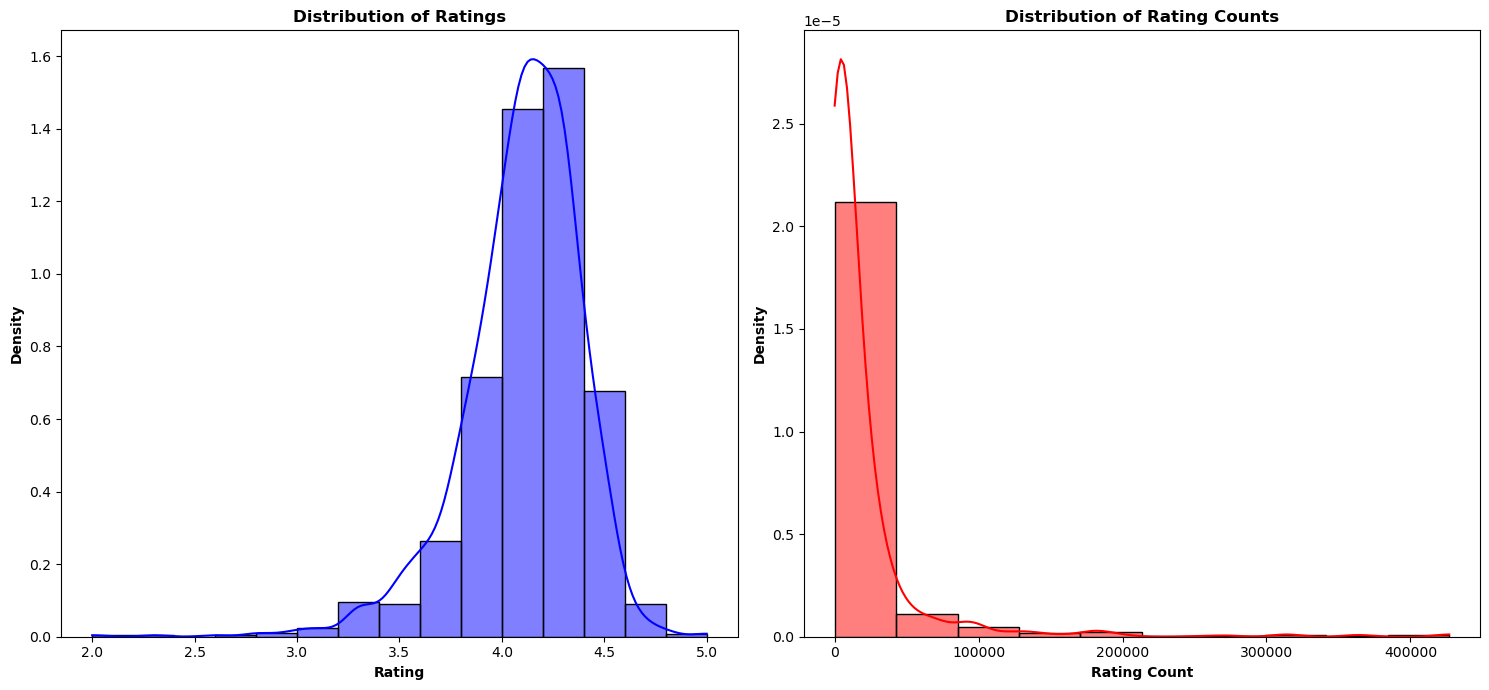

In [15]:
fig, axis = plt.subplots(1, 2, figsize=(15, 7))
filtered_rating = df[df['rating'] >= 0]['rating']
filtered_rating_count = df[df['rating_count'] >= 0]['rating_count']

sns.histplot(filtered_rating, bins=15, kde=True, ax=axis[0], color='blue', stat="density")
axis[0].set_title('Distribution of Ratings', fontweight='bold')
axis[0].set_xlabel('Rating', fontweight='bold')
axis[0].set_ylabel('Density', fontweight='bold')

sns.histplot(filtered_rating_count, bins=10, kde=True, ax=axis[1], color='red', stat="density")
axis[1].set_title('Distribution of Rating Counts', fontweight='bold')
axis[1].set_xlabel('Rating Count', fontweight='bold')
axis[1].set_ylabel('Density', fontweight='bold')

plt.tight_layout()
plt.show()

The distribution of product ratings displays a left-skewed distribution. The majority of products tend to receive higher ratings.

On the other hand, when we look at the number of ratings each product received, it tells a different story. Most products have a small to moderate number of ratings, usually between 0 and 5000. However, there are a few products that stand out because they have received an unusually large number of ratings, going well beyond 40000. This means that while most products have a moderate level of feedback, a handful have become incredibly popular and received a lot of attention from users.

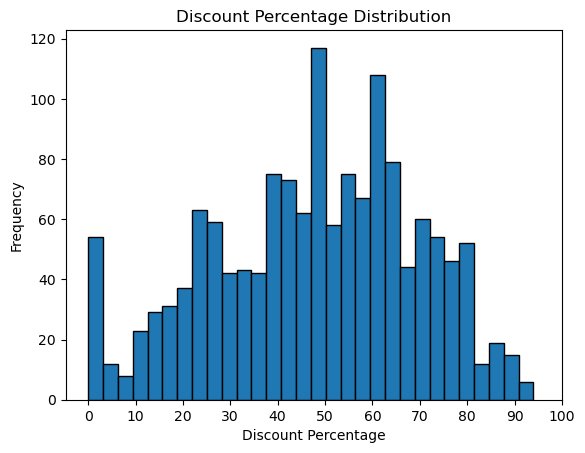

In [16]:
plt.hist(df['discount_percentage'], bins=30, edgecolor='black')
plt.title('Discount Percentage Distribution')
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')
plt.xticks(range(0, 101, 10))
plt.show()

Grouped Categories and Counts:
Other                      7
OfficeProducts            31
Home&Kitchen             448
Computers&Accessories    453
Electronics              526
Name: category_simplified, dtype: int64


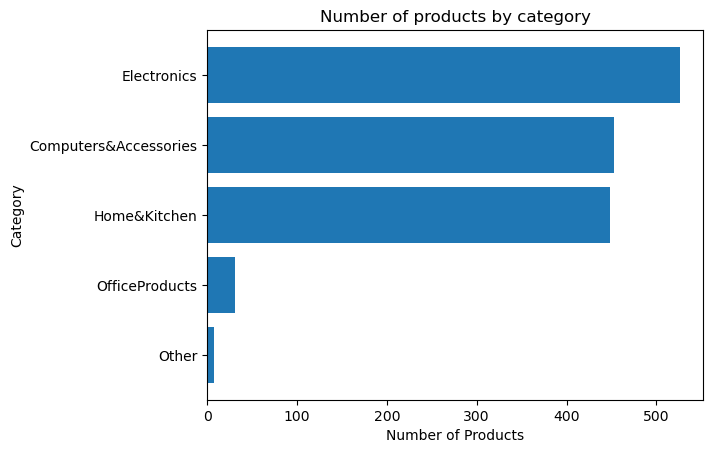

In [17]:
category_counts = df['category_simplified'].value_counts()
threshold = 30
categories_to_group = category_counts[category_counts < threshold].index

# Group categories below the threshold into "Other"
category_counts_grouped = category_counts.copy()
category_counts_grouped.loc['Other'] = category_counts.loc[categories_to_group].sum()
category_counts_grouped = category_counts_grouped.drop(categories_to_group)
category_counts_grouped = category_counts_grouped.sort_values(ascending=True)

print("Grouped Categories and Counts:")
print(category_counts_grouped)

plt.barh(category_counts_grouped.index, category_counts_grouped)
plt.title("Number of products by category")
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.show()

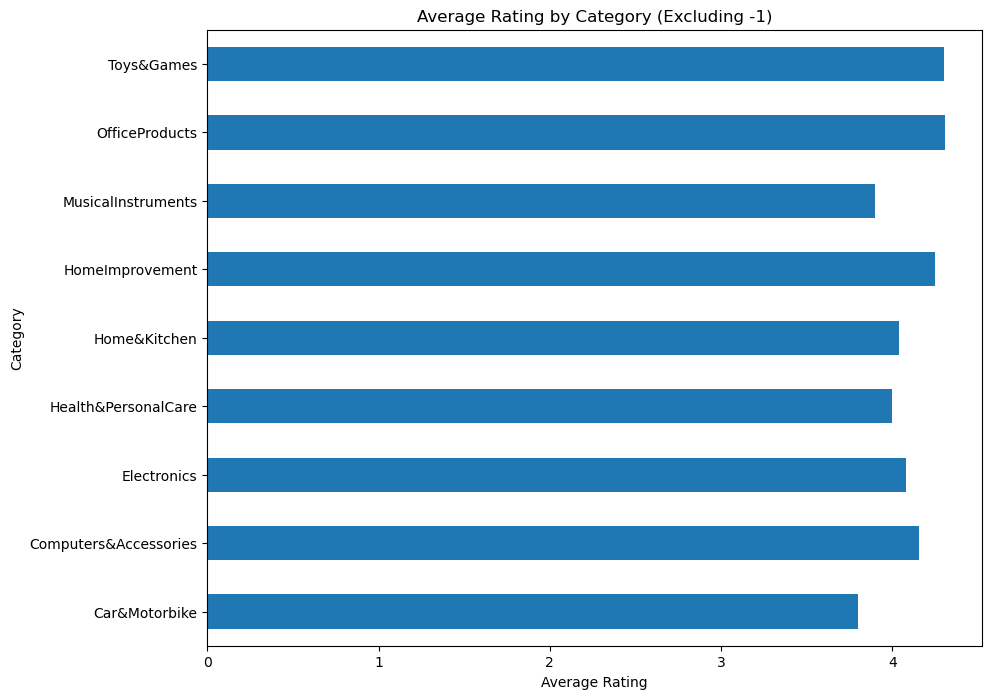

In [18]:
filtered_df = df[df['rating'] != -1]
average_rating_by_category = filtered_df.groupby('category_simplified')['rating'].mean()

plt.figure(figsize=(10, 8))
average_rating_by_category.plot(kind='barh')
plt.title("Average Rating by Category (Excluding -1)")
plt.xlabel("Average Rating")
plt.ylabel("Category")
plt.show()


The box plots help us understand how prices are distributed within each category. Outliers are not shown as dots to keep the visualization clear. By comparing the boxes, we can easily see the variation in prices between different categories.

<Figure size 1200x600 with 0 Axes>

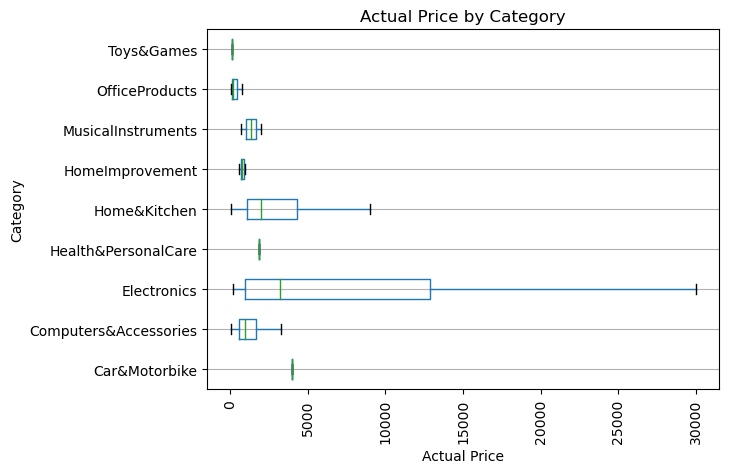

In [19]:
plt.figure(figsize=(12, 6))
boxplot = df.boxplot(column='actual_price', by='category_simplified', vert=False, showfliers=False)
plt.title("Actual Price by Category")
plt.xlabel("Actual Price")
plt.ylabel("Category")
plt.suptitle("")

plt.xticks(rotation=90)  
plt.grid(axis='x')      
plt.show()

We have already examined the distribution of actual prices within each category. Now, let's visualize how the distribution of discount percentages varies across

<Figure size 1200x600 with 0 Axes>

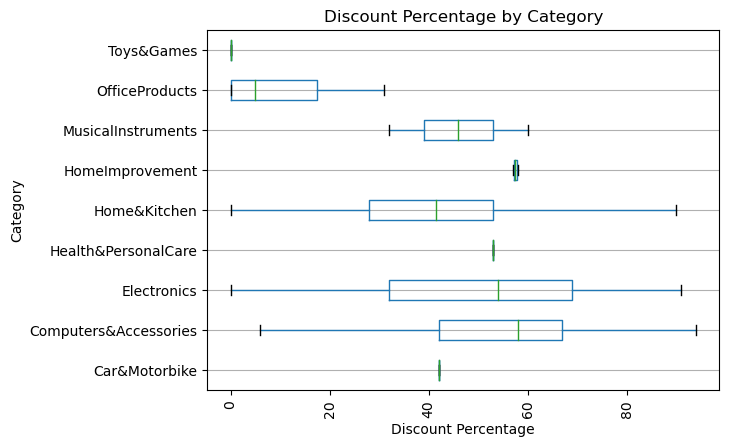

In [20]:
plt.figure(figsize=(12, 6))
boxplot = df.boxplot(column='discount_percentage', by='category_simplified', vert=False, showfliers=False)
plt.title("Discount Percentage by Category")
plt.xlabel("Discount Percentage")
plt.ylabel("Category")
plt.suptitle("")

plt.xticks(rotation=90)
plt.grid(axis='x')
plt.show()

#### Let's take a look at correlation coefficients.

Correlation coefficients are essential statistical measures that quantitatively assess the strength and direction of a linear relationship between two numerical variables. These coefficients provide valuable insights into how changes in one variable are connected to changes in another variable. By calculating correlation coefficients, we can evaluate the extent of linear interdependence between the two variables.

Symbolized by the letter "r," the correlation coefficient exists within a range from -1 to 1, representing various relationships:

    Positive Correlation (r > 0): When the value of one variable increases, the value of the other variable tends to increase as well. A higher correlation coefficient closer to 1 indicates a stronger positive correlation, meaning the two variables move in a similar direction.

    Negative Correlation (r < 0): An increase in one variable's value is linked to a decrease in the other variable's value. A lower correlation coefficient closer to -1 signifies a stronger negative correlation, where the variables move in opposite directions.

    No Correlation (r = 0): When the correlation coefficient is around 0, it suggests that no discernible linear relationship exists between the variables. Changes in one variable do not predictably coincide with changes in the other.

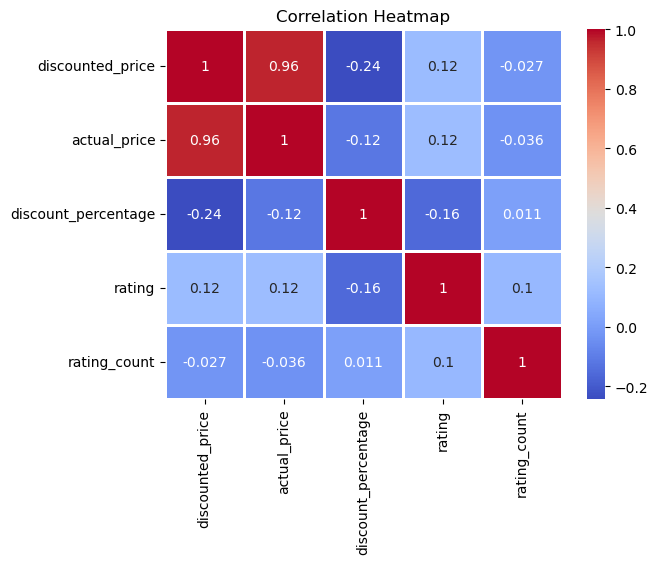

In [21]:
# Do not modify existing dataframe
new_df = df.copy()
new_df['rating'].replace(-1, np.nan, inplace=True)
new_df['rating_count'].replace(-1, np.nan, inplace=True)

correlation_matrix = new_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

We have positive correlation between actual price and discounted price. This correlation suggests that as the actual price increases, the discounted price also tends to rise.

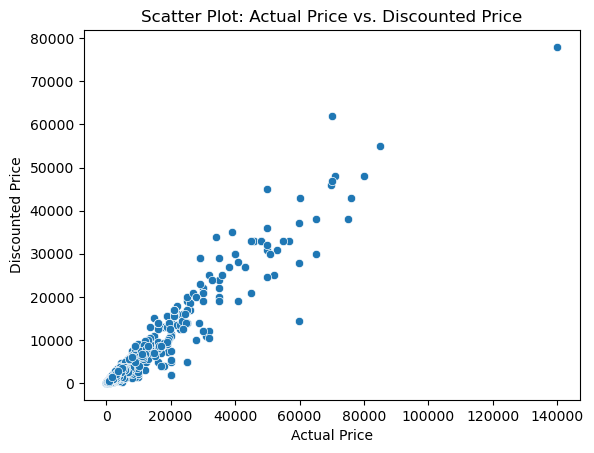

In [22]:
sns.scatterplot(data=df, x='actual_price', y='discounted_price')
plt.title('Scatter Plot: Actual Price vs. Discounted Price')
plt.xlabel('Actual Price')
plt.ylabel('Discounted Price')
plt.show()

### Hypotesis testing

In this analysis, we are performing a hypothesis test to determine whether there is a significant difference in the mean actual prices of products between the 'Electronics' and 'Home&Kitchen' categories.
We will conduct a statistical Two-Sample T-Test. The code calculates a p-value, which is then compared to a significance level of 5 percent. The 5 percent level of significance is the most common in practice. If the p-value falls below this threshold, it implies a substantial disparity in prices between the categories, prompting the rejection of the null hypothesis. Conversely, if the p-value exceeds the threshold, there is insufficient evidence to reject the null hypothesis, suggesting that any observed price differences might be due to chance. This analysis aims to elucidate whether the two categories exhibit a statistically significant discrepancy in their mean actual prices.


#### Null Hypothesis ($H_0$):
The population mean of actual prices for products in the 'Electronics' category ($\mu_{\text{electronics}}$) is **equal to** the population mean of actual prices for products in the 'Home&Kitchen' category ($\mu_{\text{home}}$).

$$H_0: \mu_{\text{electronics}} = \mu_{\text{home}}$$

#### Alternative Hypothesis ($H_1$):
The population mean of actual prices for products in the 'Electronics' category ($\mu_{\text{electronics}}$) is **not equal to** the population mean of actual prices for products in the 'Home&Kitchen' category ($\mu_{\text{home}}$).

$$H_1: \mu_{\text{electronics}} \neq \mu_{\text{home}}$$

In [23]:
electronics = df[df['category_simplified'] == 'Electronics']['actual_price']
home = df[df['category_simplified'] == 'Home&Kitchen']['actual_price']

test_result = ttest_ind(electronics, home, equal_var=False)
significance_level = 0.05

print("P-value:", test_result.pvalue)
if test_result.pvalue <= significance_level:
    print("The differences are significant. Reject the H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")


P-value: 5.822899004951884e-15
The differences are significant. Reject the H0.


Hence, we can conclude that the average prices in the 'Electronics' and 'Home&Kitchen' categories are noticeably different and statistically significant, backed by a very small p-value well below the 5% level. Moreover, the observed difference is so significant that even if we had been more stringent in our analysis, the outcome would remain unchanged.

This points to significant variations in how 'Electronics' and 'Home&Kitchen' items are priced. This divergence could stem from multiple factors like the complexity of products, what customers prefer, or how the market behaves. For instance, technological advancements or brand reputation might drive 'Electronics' prices higher, while 'Home&Kitchen' items might be priced more accessibly to cater to a broader audience

### Data Modeling

We aim to perform a data modeling task to predict the discounted price of products based on several key features. We will start by excluding rows with missing or -1 values in the 'rating_count' and 'rating' columns, ensuring that our dataset contains only relevant and complete data. Then we will select the independent variables: rating count, product rating, discount percentage, and actual price. The dependent variable that we want to predict is the discount price. We then will split the dataset into training and testing sets using an 80-20 ratio, with a fixed random seed to ensure reproducibility.

Using a fixed random seed can be helpful when you want to:

1. Ensure reproducibility: When we share our code or need to reproduce our results, using the same random seed ensures that others can replicate our work exactly.

2. Debugging: If we encounter issues or unexpected results, fixing the random seed can help in debugging because we can trace back to the same random outcomes.

3. Consistency: It allows for consistency in results when comparing different models or tuning hyperparameters. If we don't set a random seed, you might get different results each time we run the code.

<hr>
    
Next, we will normalize the feature data using <b>Min-Max scaling</b> to bring all the features within a common range, usually between 0 and 1. It will be calculated using the formula:

$$X_{\text{normalized}} = \frac{{X - X_{\text{min}}}}{{X_{\text{max}} - X_{\text{min}}}}$$

<hr>

Two different regression models will be trained and evaluated:

1. <b>Linear Regression Model</b>: We will create and train a linear regression model using the training data. This model will aim to establish a linear relationship between the selected features and the discounted price.

2. <b>Decision Tree Regression Model</b>: A decision tree regression model will also develop and train using the same training data. Decision trees can capture nonlinear relationships between features and the target variable.

In [24]:
# Excluding rows with -1 values in 'rating_count' and 'rating' columns
df = df[(df['rating_count'] != -1) & (df['rating'] != -1)]
X = df[['rating_count', 'rating', 'discount_percentage', 'actual_price']]
y = df['discounted_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Create and train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_normalized, y_train)

# Create and train a Decision Tree Regression model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train_normalized, y_train)

linear_y_pred = linear_model.predict(X_test_normalized)
linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, linear_y_pred)
linear_r2 = r2_score(y_test, linear_y_pred)

tree_y_pred = decision_tree_model.predict(X_test_normalized)
tree_mse = mean_squared_error(y_test, tree_y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(y_test, tree_y_pred)
tree_r2 = r2_score(y_test, tree_y_pred)

print("Linear Regression Results:")
print(f"Mean Squared Error (MSE): {linear_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {linear_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {linear_mae:.2f}")
print(f"R-squared (R2) Score: {linear_r2:.2f}")

print("\nDecision Tree Regression Results:")
print(f"Mean Squared Error (MSE): {tree_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {tree_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {tree_mae:.2f}")
print(f"R-squared (R2) Score: {tree_r2:.2f}")

Linear Regression Results:
Mean Squared Error (MSE): 1439063.82
Root Mean Squared Error (RMSE): 1199.61
Mean Absolute Error (MAE): 733.42
R-squared (R2) Score: 0.95

Decision Tree Regression Results:
Mean Squared Error (MSE): 698648.72
Root Mean Squared Error (RMSE): 835.85
Mean Absolute Error (MAE): 179.82
R-squared (R2) Score: 0.98


The evaluation of these models provided us with insights into their predictive accuracy and generalization performance. Here are the key evaluation metrics used:

1. <b>Mean Squared Error (MSE)</b>: This metric quantifies the average squared difference between the predicted and actual discounted prices. Lower MSE values indicate better model accuracy.

2. <b>Root Mean Squared Error (RMSE)</b>: RMSE is the square root of MSE and provides a measure of the average prediction error. It is in the same units as the target variable.

3. <b>Mean Absolute Error (MAE)</b>: MAE measures the average absolute difference between predicted and actual values. It is robust to outliers.

4. <b>R-squared (R2) Score</b>: R2 score assesses the proportion of variance in the discounted price that is explained by our model. Higher R2 scores indicate better model fit.

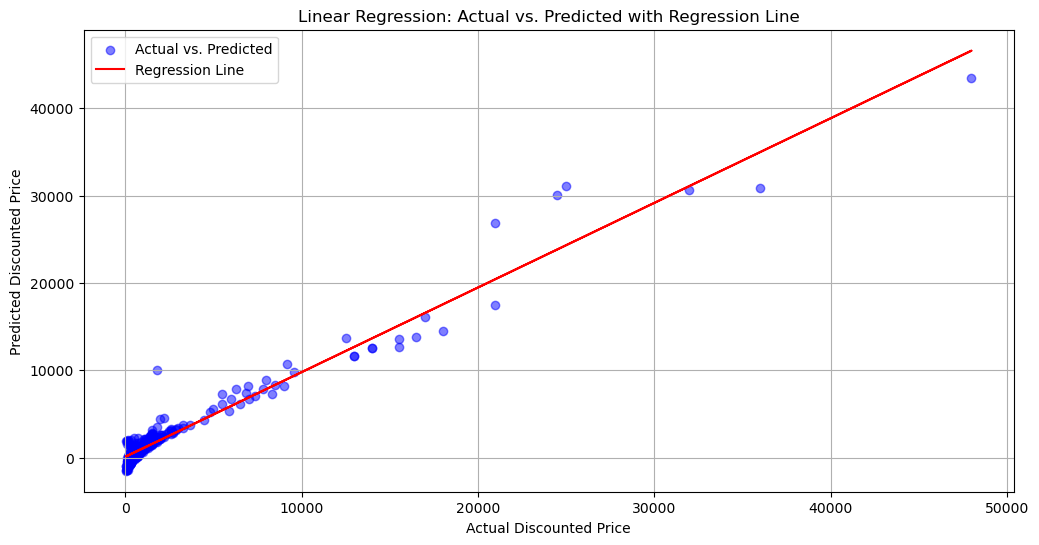

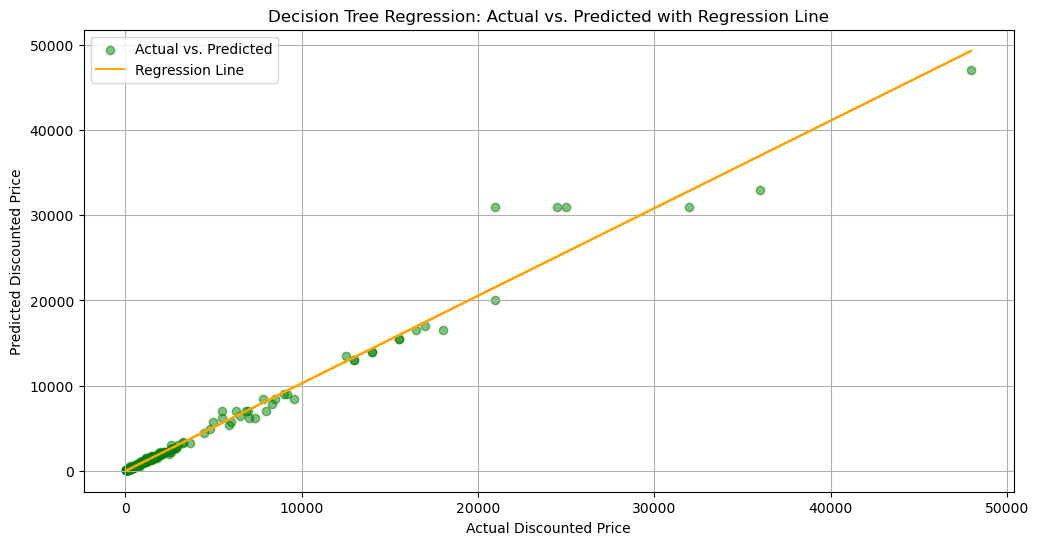

In [25]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, linear_y_pred, alpha=0.5, color='blue', label='Actual vs. Predicted')
plt.title("Linear Regression: Actual vs. Predicted with Regression Line")
plt.xlabel("Actual Discounted Price")
plt.ylabel("Predicted Discounted Price")

linear_fit = np.polyfit(y_test, linear_y_pred, 1)
linear_fit_fn = np.poly1d(linear_fit)
plt.plot(y_test, linear_fit_fn(y_test), color='red', label='Regression Line')

plt.grid(True)
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.scatter(y_test, tree_y_pred, alpha=0.5, color='green', label='Actual vs. Predicted')
plt.title("Decision Tree Regression: Actual vs. Predicted with Regression Line")
plt.xlabel("Actual Discounted Price")
plt.ylabel("Predicted Discounted Price")

tree_fit = np.polyfit(y_test, tree_y_pred, 1)
tree_fit_fn = np.poly1d(tree_fit)
plt.plot(y_test, tree_fit_fn(y_test), color='orange', label='Regression Line')
plt.grid(True)
plt.legend()
plt.show()

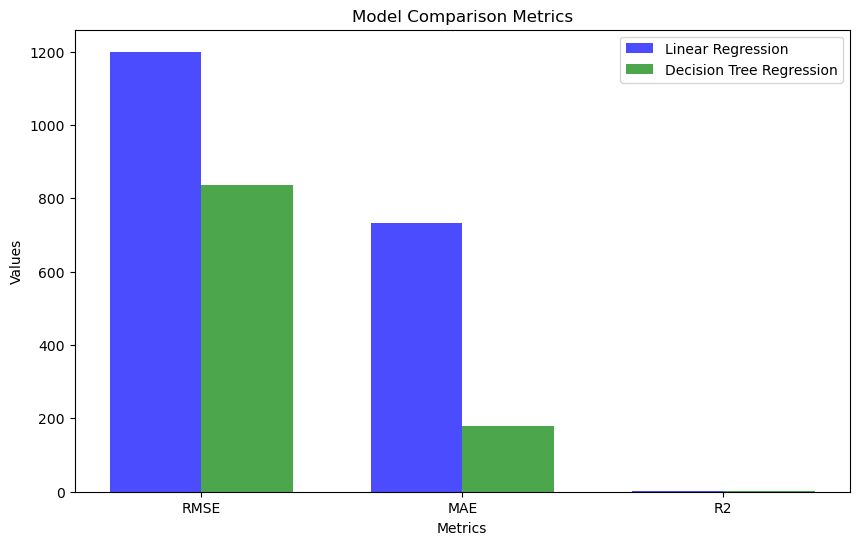

In [26]:
metrics = ['RMSE', 'MAE', 'R2']
linear_metrics = [linear_rmse, linear_mae, linear_r2]
tree_metrics = [tree_rmse, tree_mae, tree_r2]
plt.figure(figsize=(10, 6))
x = range(len(metrics))
width = 0.35

plt.bar(x, linear_metrics, width, label='Linear Regression', color='b', alpha=0.7)
plt.bar([i + width for i in x], tree_metrics, width, label='Decision Tree Regression', color='g', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks([i + width/2 for i in x], metrics)
plt.title('Model Comparison Metrics')
plt.legend()
plt.show()

In summary, the <b>Decision Tree Regression</b> model outperforms the <b>Linear Regression</b> model in terms of MSE, RMSE, and MAE. It also has a higher R2 score, indicating a better fit to the data. Therefore, the Decision Tree model appears to be a more suitable choice for predicting discounted prices based on the given features. 

1. https://www.sciencedirect.com/topics/mathematics/significance-level-alpha
2. https://www.investopedia.com/terms/h/hypothesistesting.asp
3. https://www.simplypsychology.org/boxplots.html
4. https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset
5. https://www.ibm.com/topics/linear-regression
6. https://www.surveysystem.com/correlation.htm
7. https://www.intellspot.com/types-graphs-charts/
8. https://statisticsbyjim.com/basics/skewed-distribution/
9. https://medium.com/@oluwatobimesh/comparing-machine-learning-models-using-mean-absolute-error-mae-mean-absolute-percentage-error-93612c284fb8
10. https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html